# Setup

In [ ]:
!python -m pip install -U pip
!python -m pip install pillow-heif
!pip install rembg
!pip install PIL

In [1]:
import os
import glob
from PIL import Image
from pillow_heif import register_heif_opener
from rembg import remove
import glob
import shutil
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, Input

# Preprocessing

<ul>
    <li>Resize the images to 512x512</li>
    <li>Remove background noise</li>
    <li>Convert from RBGA to RGB</li>
    <li>Save it with proper format -JPEG- in another file</li>
</ul>

In [ ]:
register_heif_opener() # Enable support for HEIF images, including HEIC, AVIF, and other formats

# Define target format (e.g., JPEG), size (e.g., 224x224), and quality (0-100)
target_format = "JPEG"
target_size = (512, 512)
quality = 100

# Define path to your image directory
for classname in ['rock', 'paper', 'scissor']:
    src_dir = f"..\\..\\raw_data\\{classname}"
    dst_dir = f"..\\datasets\\procssed_data\\{classname}"

    os.makedirs(dst_dir, exist_ok=True) # Create destination directory if it doesn't exist

    # Find all images using glob
    for filepath in glob.glob(f"{src_dir}\\*"):
        try:
            # Open image with Pillow
            img = Image.open(filepath)
            
            # Resize image
            img = img.resize(target_size)
            
            # Removing the background from the given Image 
            img = remove(img)
            
            # Convering it to the proper format RGB instead of RBGA
            img = img.convert('L') # 'L' for black and white :)

            # Convert to target format and compress
            filename = filepath.split("\\")[-1].split(".")[0]
            img.save(f"{dst_dir}/{filename}.{target_format}", target_format, quality=quality)

            print(f"Converted to JPEG, resized and background removed {filepath}")
        except (OSError, IOError) as e:
            print('somthing went wrong in image proccecing',e)

### Making sure JPEG is the only format in the output

In [ ]:
formats = set()
filepaths = glob.glob('..\\datasets\\procssed_data\\*\\*')

for f in filepaths:
    formats.add(f.split('.')[-1].lower())

print(f'{formats} Must be only JPEG/JPG')

{'jpeg'} Must be only JPEG/JPG


### Count number of `input` vs `output` 

In [ ]:
filepaths_not_processed = glob.glob('..\\..\\raw_data\\*\\*')
filepaths_processed = glob.glob('..\\datasets\\procssed_data\\*\\*')
print(f'{len(filepaths_not_processed)} is number of images in raw_data')
print(f'{len(filepaths_processed)} is number of images in processed_data')

843 is number of images in raw_data
841 is number of images in processed_data


# Split dataset into `train` and `test` folders

## Loading image names with their labels as keys

 `{ paper:['img'...], rock:[...], ... }`

In [ ]:
images = {}

for filename in glob.glob('..\\datasets\\procssed_data\\*\\*'):
    split = filename.split('\\')
    classname = split[-2]
    if classname not in images:
        images[classname] = []
    images[classname].append(split[-1])

In [ ]:
images

{'paper': ['07be22f1-aa8b-426a-a828-2a16ee45f56c.JPEG',
  '168c8763-7f2e-4d74-af77-a61f1b894e74.JPEG',
  '20240501_184502.JPEG',
  '20240501_184657.JPEG',
  '20240501_191022.JPEG',
  '20240501_213502.JPEG',
  '20240502_085102.JPEG',
  '20240502_085109.JPEG',
  '20240502_085128.JPEG',
  '20240502_085130.JPEG',
  '20240502_085138.JPEG',
  '20240503_103557(0).JPEG',
  '20240503_103558(0).JPEG',
  '20240503_103558.JPEG',
  '20240503_103559.JPEG',
  '20240503_103600(0).JPEG',
  '20240503_103600.JPEG',
  '20240503_103601(0).JPEG',
  '20240503_103601(1).JPEG',
  '20240503_103601.JPEG',
  '20240503_103602.JPEG',
  '20240503_103603.JPEG',
  '20240503_103604.JPEG',
  '20240503_103611.JPEG',
  '20240503_103612(0).JPEG',
  '20240503_103612.JPEG',
  '20240503_103613(0).JPEG',
  '20240503_103613.JPEG',
  '20240503_103614(0).JPEG',
  '20240503_103614(1).JPEG',
  '20240503_103614.JPEG',
  '20240503_103615(0).JPEG',
  '20240503_103615.JPEG',
  '20240503_103616(0).JPEG',
  '20240503_103616.JPEG',
  '202

In [ ]:
# For demestration only
x = [50, 70, 90]
random.shuffle(x)
x

[70, 50, 90]

## Splite by copying them to a new folder

In [ ]:
for classname in images.keys():
    # shuffl the images
    random.shuffle(images[classname])

for classname in images.keys():
    os.makedirs(f'..\\datasets\\data_split\\train\\{classname}', exist_ok=True)
    os.makedirs(f'..\\datasets\\data_split\\valid\\{classname}', exist_ok=True)
    os.makedirs(f'..\\datasets\\data_split\\test\\{classname}', exist_ok=True)

    # 70% for training , 20% validation and 10% testing
    for i, image in enumerate(images[classname]):
        if i < len(images[classname]) * 0.7:
            shutil.copyfile(f'..\\datasets\\procssed_data\\{classname}/{image}', f'..\\datasets\\data_split\\train\\{classname}/{image}')
        elif i < len(images[classname]) * 0.9:
            shutil.copyfile(f'..\\datasets\\procssed_data\\{classname}/{image}', f'..\\datasets\\data_split\\valid\\{classname}/{image}')
        else:
            shutil.copyfile(f'..\\datasets\\procssed_data\\{classname}/{image}', f'..\\datasets\\data_split\\test\\{classname}/{image}')

## Load `train`, `test` and `val` from the new folder data_split

In [2]:
IMG_SIZE = 512
BATCH_SIZE = 32

splited_data_dir = "..\\datasets\\data_split"

# Load training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    splited_data_dir + '\\train',
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
)

# Load validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    splited_data_dir + '\\valid',
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
)

# Load test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    splited_data_dir + '\\test',
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
)


print(train_ds.class_names)

Found 590 files belonging to 3 classes.
Found 169 files belonging to 3 classes.
Found 82 files belonging to 3 classes.
['paper', 'rock', 'scissor']


### A sample

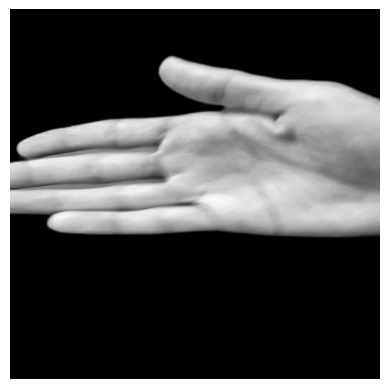

In [ ]:
def display_image(image):
    plt.axis('off')
    plt.imshow(image,cmap='gray')

for images, label in val_ds.take(1):
    display_image(images[0])
    break

# Neurons network architectures

In [5]:
input_shape = (512, 512, 1)

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.GlobalAveragePooling2D(), 
    
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_5           │ (None, 512, 512, 1)    │             4 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 510, 510, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 510, 510, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 255, 255, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 253, 253, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 253, 253, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 126, 126, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 124, 124, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 124, 124, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,999 (238.28 KB)

 Trainable params: 60,549 (236.52 KB)

 Non-trainable params: 450 (1.76 KB)

In [8]:
history = model.fit(train_ds, validation_data=val_ds,epochs=10)

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 86s 5s/step - accuracy: 0.7544 - loss: 0.5932 - val_accuracy: 0.3432 - val_loss: 2.6063
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 155s 8s/step - accuracy: 0.7384 - loss: 0.6256 - val_accuracy: 0.3432 - val_loss: 2.9205
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 149s 8s/step - accuracy: 0.7951 - loss: 0.5503 - val_accuracy: 0.3432 - val_loss: 3.2390
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 158s 8s/step - accuracy: 0.8045 - loss: 0.5476 - val_accuracy: 0.3432 - val_loss: 2.8540
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 166s 8s/step - accuracy: 0.8150 - loss: 0.5023 - val_accuracy: 0.3432 - val_loss: 3.5628
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 152s 8s/step - accuracy: 0.8268 - loss: 0.4433 - val_accuracy: 0.3432 - val_loss: 3.4228
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 183s 10s/step - accuracy: 0.8223 - loss: 0.5060 - val_accuracy: 0.3432 - val_loss: 3.2772
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 240s 12s/step - accuracy: 0.8426 - loss: 0.4197 - val_accuracy: 0.3432 - 